# 🎓 **Taller 4.7.1: Taller de Métodos de Clustering Basados en Modelos Probabilisticos**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a ver cómo funcionan los algoritmos de clustering basado en Modelos Probabilísticos como GMM.

Los objetivos específicos son:

* Introducir los fundamentos teóricos de los métodos de agrupamiento probabilísticos, en particular los Modelos de Mezclas Gaussianas (GMM), entendiendo cómo modelan los datos como una combinación de distribuciones normales multivariadas.

* Comprender el algoritmo de optimización EM (Expectation-Maximization) utilizado para estimar los parámetros del modelo (medias, covarianzas y pesos de cada componente).

# 🔧 **CONFIGURACIÓN INICIAL**

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [123]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

# 🎯 **1:Cree el Algoritmo de Clustering GMM**

El algoritmo EM tiene un único parámetro: el número de clústeres (K). Una vez fijado este valor, el primer paso consiste en inicializar el modelo. Se eligen unos centros iniciales de manera aleatoria, unas matrices de covarianzas fijas y unos pesos iniciales para las diferentes componentes. Sin más información, lo más normal sería asignar a todas las componentes el mismo peso.


In [124]:
def asignar_cov_iniciales(K):
  # Asignar unas matrices de covarianzas iniciales
  sigmas = []
  for k in np.arange(K):
      sigmas.append( np.diag( 0.1 * np.ones( Dx.shape[1] ) ) )
  x, y = np.mgrid[(np.min(Dx[:,0])-0.1):(np.max(Dx[:,0])+0.1):.01,
                  (np.min(Dx[:,1])-0.1):(np.max(Dx[:,1])+0.1):.01]
  pos = np.empty(x.shape + (2,))
  pos[:, :, 0] = x; pos[:, :, 1] = y
  # Inicialmente consideramos que todas las componentes tienen la misma probabilidad
  PIs = np.ones(K) / K
  return sigmas, PIs

In [125]:
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

In [126]:
def inicializar_parametros(Dx, K):
  # Elegir unos centros (uno para cada componente) de manera aleatoria
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  for d in np.arange(Dx.shape[1]):
      cDx[:,d] = random_sample_float(K, np.min(Dx[:,d]), np.max(Dx[:,d]))
  print('Los centros iniciales elegidos aleatoriamente son:')
  print(cDx)
  # calcularlas covarianzas iniciales
  sigmas, PIs = asignar_cov_iniciales(K)
  return cDx, sigmas, PIs

En el paso E se (re)calcula la probabilidad de que cada ejemplo pertenezca a cada una de las componentes (los valores  zik ).

In [127]:
def paso_E(K, Dx,cDx, sigmas, PIs):
    # Se calcula la probabilidad de que cada punto pertenezca a cada clúster.
    # multivariate_normal.pdf calcula la densidad de la distribución normal multivariada.
    Dy_probs = np.full((Dx.shape[0], K), fill_value=np.nan, dtype=np.float64)
    for k in np.arange(K):
        try:
            Dy_probs[:, k] = PIs[k] * multivariate_normal.pdf(Dx, mean=cDx[k, :], cov=sigmas[k])
        except np.linalg.LinAlgError as e:
            # Añadir un pequeño valor a la diagonal para evitar problemas de singularidad
            sigmas[k] += np.eye(4) * 1e-6
            Dy_probs[:, k] = PIs[k] * multivariate_normal.pdf(Dx, mean=cDx[k, :], cov=sigmas[k])
    #Se asegura que Dy_probs se normalice para que las probabilidades sumen 1 en cada fila.
    sum_Dy_probs = np.sum(Dy_probs, axis=1)
    sum_Dy_probs[sum_Dy_probs == 0] = 1e-10     # Evitar la división por cero
    Dy_probs = Dy_probs / sum_Dy_probs[:, np.newaxis]
    return Dy_probs

En el paso M se (re)calculan los parámetros del modelo: los centros de las distribuciones normales (uno por componente,  μk ), las matrices de covarianzas de las normales (una por componente,  Σk ) y los coeficientes de importancia de las diferentes componentes ( {πk}Kk=1 , con  ∑kπk=1 ).

In [128]:
def paso_M(K, Dx, Dy_probs):
    # - a: Calcular los nuevos centros de las K componentes
    cDx = np.zeros((K, Dx.shape[1]))
    for k in range(K):
        cDx[k,:] = np.sum(Dy_probs[:,k,None]*Dx,axis=0)/np.sum(Dy_probs[:,k])
    # - b: Calcular la matriz de covarianza (sigma) de las K componentes
    sigmas = np.zeros((K, Dx.shape[1], Dx.shape[1]))
    for k in range(K):
        sigmas[k] = np.sum([Dy_probs[i,k]* np.dot(Dx[i,:,None]-cDx[k,:,None],
                                                  (Dx[i,:,None]-cDx[k,:,None]).transpose())
                          for i in np.arange(Dx.shape[0])], axis=0) / np.sum(Dy_probs[:,k])
    # - c: Calcular los coeficientes de importancia de las diferentes componentes
    PIs = np.sum(Dy_probs, axis=0) / Dx.shape[0]
    return cDx, sigmas, PIs

Una vez inicializado, el algoritmo EM ejecuta un bucle donde se repiten los pasos E y M hasta que se alcanza la convergencia.El algoritmo alcanza la convergencia cuando los parámetros no cambian entre dos iteraciones consecutivas.

In [129]:
def GMM(Dx, K):
  Dy_probs = np.zeros((Dx.shape[0], K))
  # Flag de convergencia
  iterando = True
  # inicializar el modelo
  cDx, sigmas, PIs = inicializar_parametros(Dx, K)
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    # PASO E:
    Dy_probs = paso_E(K, Dx,cDx, sigmas, PIs)
    # PASO M:
    cDx, sigmas, PIs = paso_M(K, Dx, Dy_probs)
    # Verificar la convergencia
    if np.allclose(cDx, cDx_ant):
        iterando = False
  Dyp = np.argmax(Dy_probs,axis=1)
  return cDx,sigmas, Dyp

Esta función permite vizualizar la asignacion de los puntos a los clusters y las distribuciones gausianas

In [130]:
from matplotlib.patches import Ellipse

def visualizar_gmm(Dx, cDx, sigmas, Dyp, titulo="Resultado GMM", padding=1):
    K = cDx.shape[0]  # Número de clusters
    plt.figure(figsize=(10, 8))
    colores = plt.cm.tab10(np.linspace(0, 1, K))

    # 1. Mostrar puntos coloreados por cluster
    for k in range(K):
        # Puntos del cluster k
        puntos_cluster = Dx[Dyp == k]
        if len(puntos_cluster) > 0:
            plt.scatter(puntos_cluster[:, 0], puntos_cluster[:, 1],
                       color=colores[k], alpha=0.6, s=40,
                       label=f'Cluster {k} (n={len(puntos_cluster)})')

    # 2. Mostrar centros de clusters
    plt.scatter(cDx[:, 0], cDx[:, 1],
               color='red', marker='X', s=200,
               edgecolors='black', linewidth=2,
               label=f'Centros (K={K})')

    # 3. Dibujar elipses de covarianza (1 desviación estándar)
    for k in range(K):
        # Obtener eigenvalores y eigenvectores de la matriz de covarianza
        eigvals, eigvecs = np.linalg.eigh(sigmas[k])

        # Calcular ángulo de rotación
        angulo = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

        # Ancho y alto de la elipse (1σ)
        ancho = 2 * np.sqrt(eigvals[0])
        alto = 2 * np.sqrt(eigvals[1])

        # Crear elipse
        elipse = Ellipse(xy=cDx[k], width=ancho, height=alto,
                        angle=angulo, alpha=0.3,
                        color=colores[k], linewidth=2, linestyle='--')

        plt.gca().add_patch(elipse)

    # 4. Calcular límites con escala igual
    x_min, x_max = Dx[:, 0].min(), Dx[:, 0].max()
    y_min, y_max = Dx[:, 1].min(), Dx[:, 1].max()

    # Calcular rangos
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Encontrar el rango máximo entre X e Y
    max_range = max(x_range, y_range)

    # Calcular centros
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    # Aplicar padding usando el mismo rango para ambos ejes
    half_range_with_padding = (max_range * padding) / 2

    # Establecer límites iguales para ambos ejes
    x_min_final = x_center - half_range_with_padding
    x_max_final = x_center + half_range_with_padding
    y_min_final = y_center - half_range_with_padding
    y_max_final = y_center + half_range_with_padding

    # Crear grid para densidad usando los límites iguales
    xx, yy = np.meshgrid(np.linspace(x_min_final, x_max_final, 100),
                         np.linspace(y_min_final, y_max_final, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Calcular densidad total (suma de todas las gaussianas)
    densidad_total = np.zeros(grid.shape[0])

    for k in range(K):
        # Usar pdf de distribución normal multivariada
        try:
            pdf_k = multivariate_normal.pdf(grid, mean=cDx[k], cov=sigmas[k])
            densidad_total += pdf_k
        except:
            # Si hay error con la covarianza, saltar esta componente
            continue

    # Mostrar contornos si hay densidad calculada
    if np.any(densidad_total > 0):
        densidad_total = densidad_total.reshape(xx.shape)
        plt.contour(xx, yy, densidad_total, levels=8, colors='black', alpha=0.5, linewidths=0.5)

    # 5. Configurar gráfico con límites iguales
    plt.xlim(x_min_final, x_max_final)
    plt.ylim(y_min_final, y_max_final)

    plt.xlabel('X₁', fontsize=12)
    plt.ylabel('X₂', fontsize=12)
    plt.title(f'{titulo} - K={K} clusters', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # Forzar mismo aspecto (relación de aspecto 1:1)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

## Ahora podemos usar GMM


✅ Dataset cargado desde URL GitHub


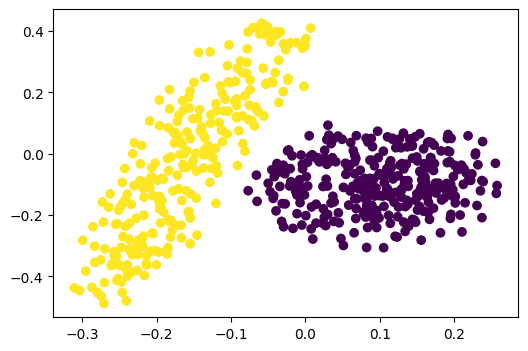

In [131]:
D =cargar_dataset("dataset_dos_guassianas.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

In [132]:
K = 2
# ejecucion de GMM
cDx, sigmas, Dyp = GMM(Dx, K)

Los centros iniciales elegidos aleatoriamente son:
[[-0.15622499  0.10160959]
 [ 0.19044237  0.20212102]]


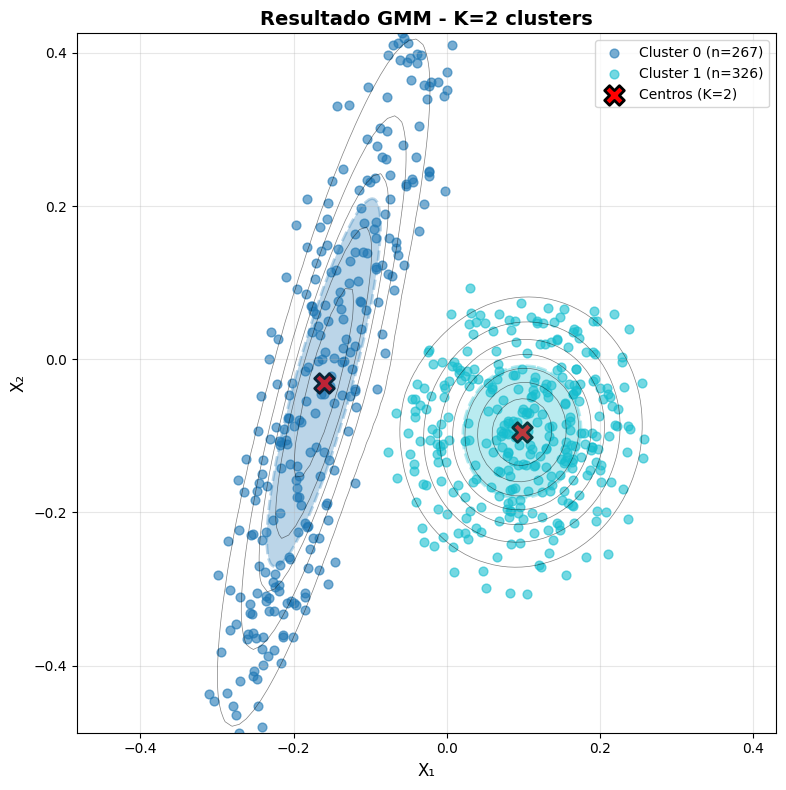

In [133]:
# Visualización
visualizar_gmm(Dx, cDx, sigmas, Dyp)

<hr>
Experimente con el dataset dos remolinos


In [134]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


In [135]:
K = 2

Los centros iniciales elegidos aleatoriamente son:
[[ 0.28746204  0.91274562]
 [-0.21400967  1.78203872]]


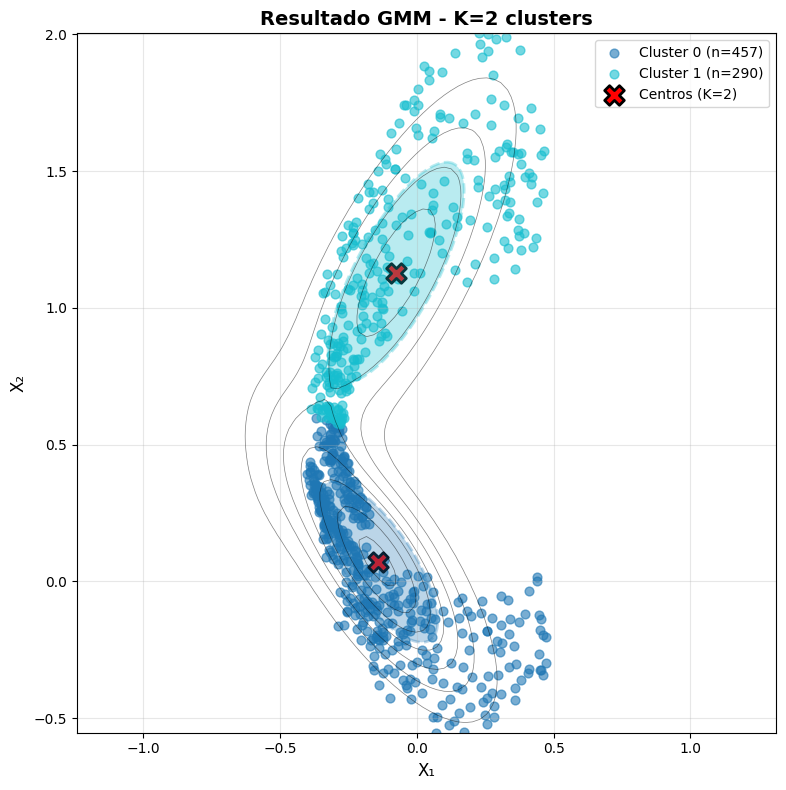

In [136]:
cDx, sigmas, Dyp = GMM(Dx, K)
visualizar_gmm(Dx, cDx, sigmas, Dyp)

Experimente con el dataset cuatro diferente medida

In [137]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


Los centros iniciales elegidos aleatoriamente son:
[[-0.30859036  0.38035734]
 [-0.02350407  0.40882358]
 [ 0.11164206  0.15045418]
 [ 0.44466248  0.18641645]]


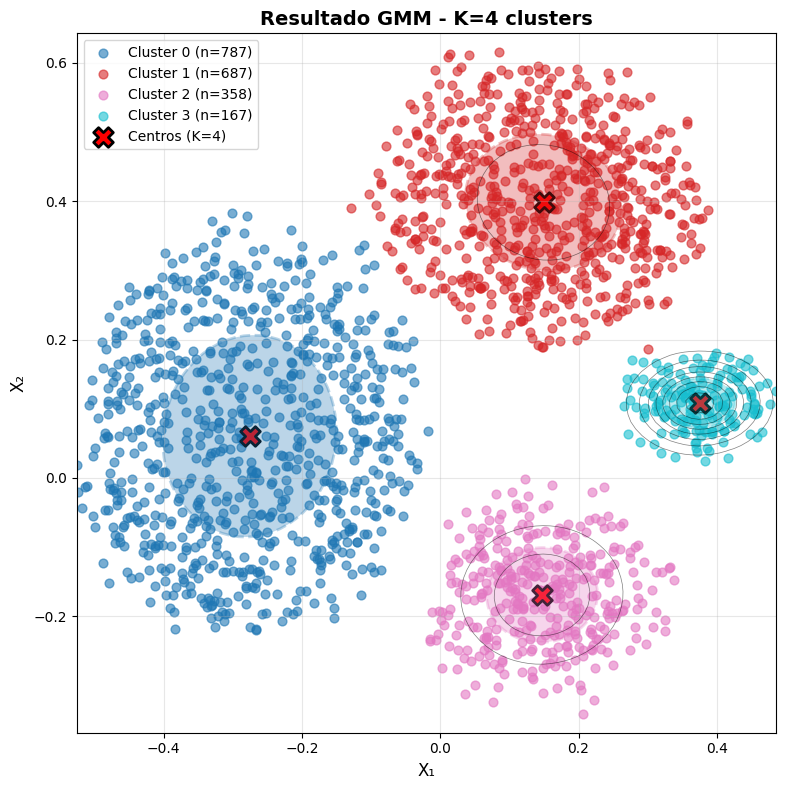

In [138]:
# p10. Complete el codigo
K = 4
cDx, sigmas, Dyp = GMM(Dx, K)
visualizar_gmm(Dx, cDx, sigmas, Dyp)

<hr>
<h2>Implementaciones en librerías de Python</h2>

Scikit-learn (scikit-learn) es la implementación más popular y ampliamente utilizada:

In [139]:
from sklearn.mixture import GaussianMixture
k=4
gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
gmm.fit(Dx)
labels = gmm.predict(Dx)
probabilities = gmm.predict_proba(Dx)

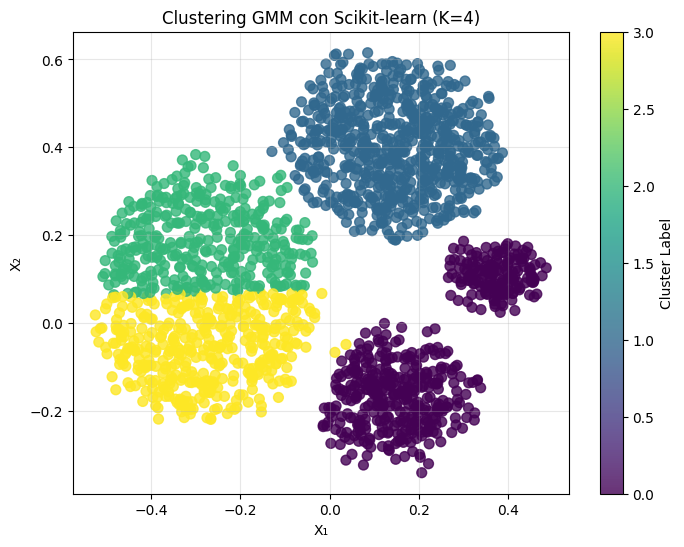

In [140]:
 # GRAFICAR LOS GRUPOS

 # P11 SU CODIGO AQUI
plt.figure(figsize=(8, 6))
plt.scatter(Dx[:, 0], Dx[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'Clustering GMM con Scikit-learn (K={k})')
plt.xlabel('X₁')
plt.ylabel('X₂')
plt.colorbar(label='Cluster Label')
plt.grid(True, alpha=0.3)
plt.show()

Pruebe GMM y BGMM con los 5 dataset


*   dataset_circulos_concentricos
*   dataset_cuatro_diferente_densidad
*   dataset_cuatro_separables_peque
*   dataset_cuatro_diferente_medida
*   dataset_inseparable




Processing dataset: dataset_circulos_concentricos.xlsx
✅ Dataset cargado desde URL GitHub


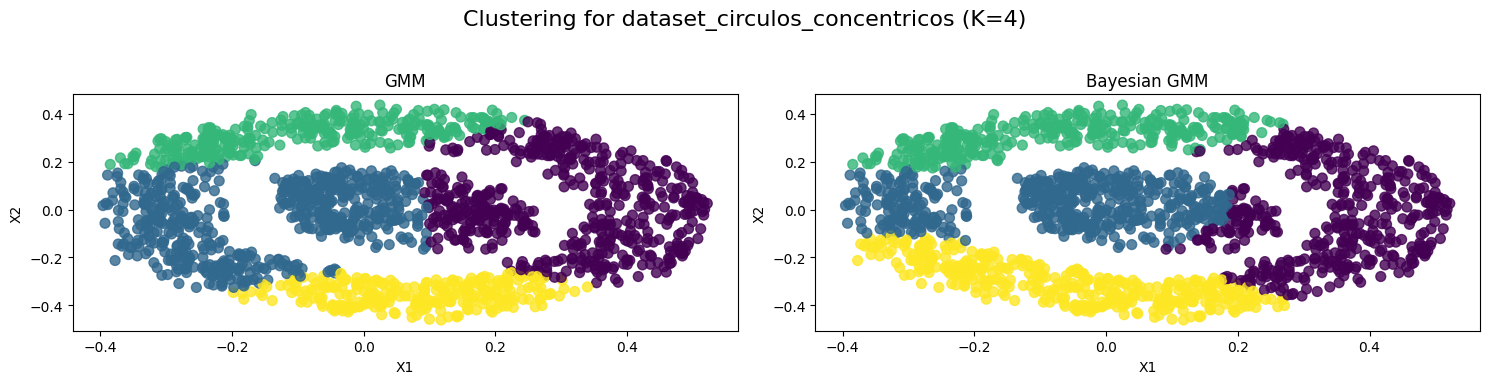


Processing dataset: dataset_cuatro_diferente_densidad.xlsx
✅ Dataset cargado desde URL GitHub


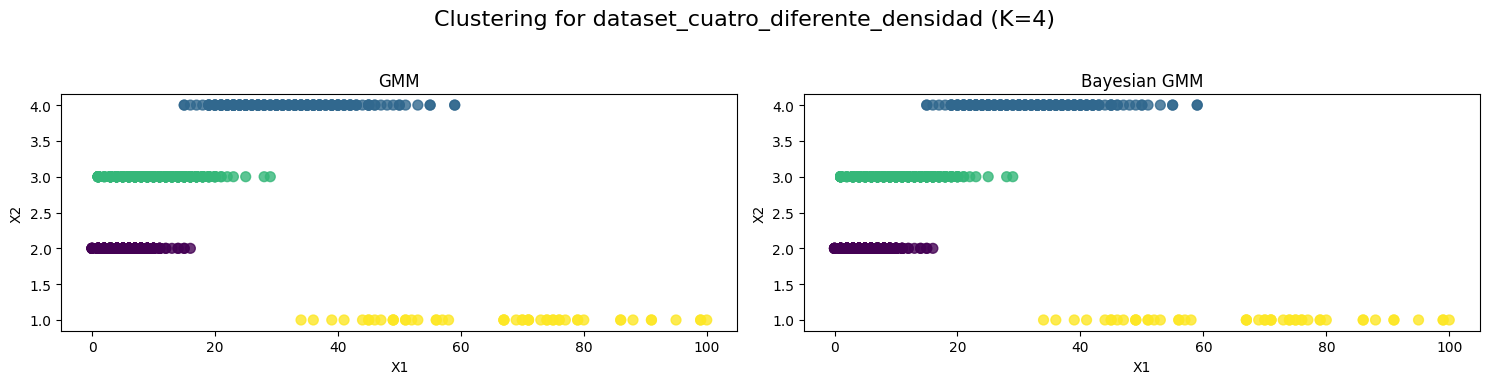


Processing dataset: dataset_cuatro_separables_peque.xlsx
✅ Dataset cargado desde URL GitHub


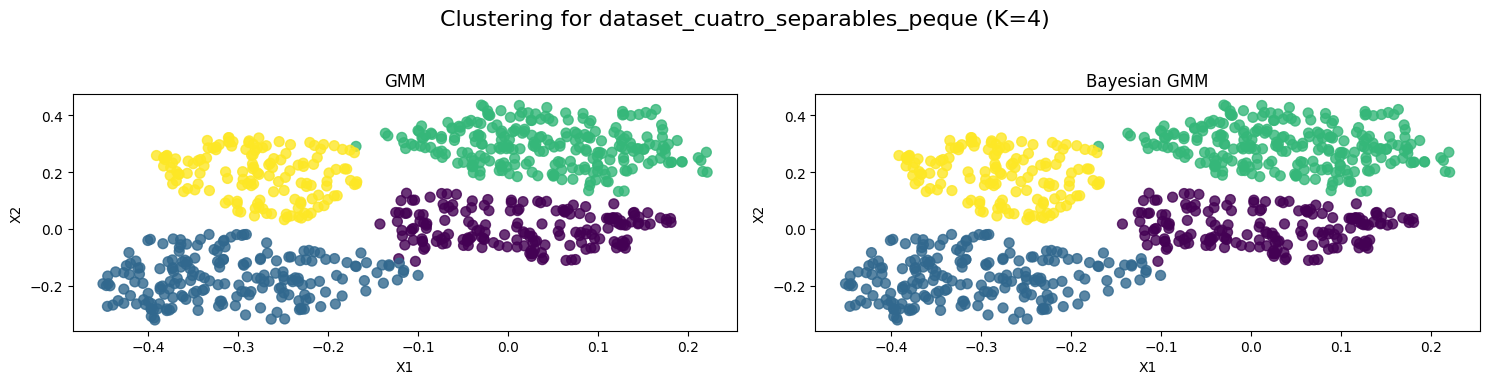


Processing dataset: dataset_cuatro_diferente_medida.xlsx
✅ Dataset cargado desde URL GitHub


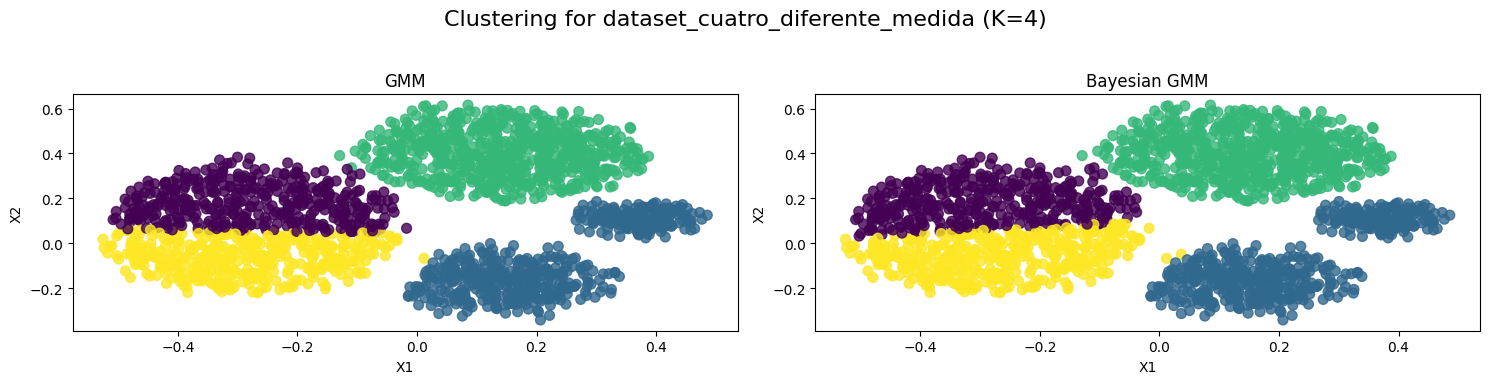


Processing dataset: dataset_inseparable.xlsx
✅ Dataset cargado desde URL GitHub


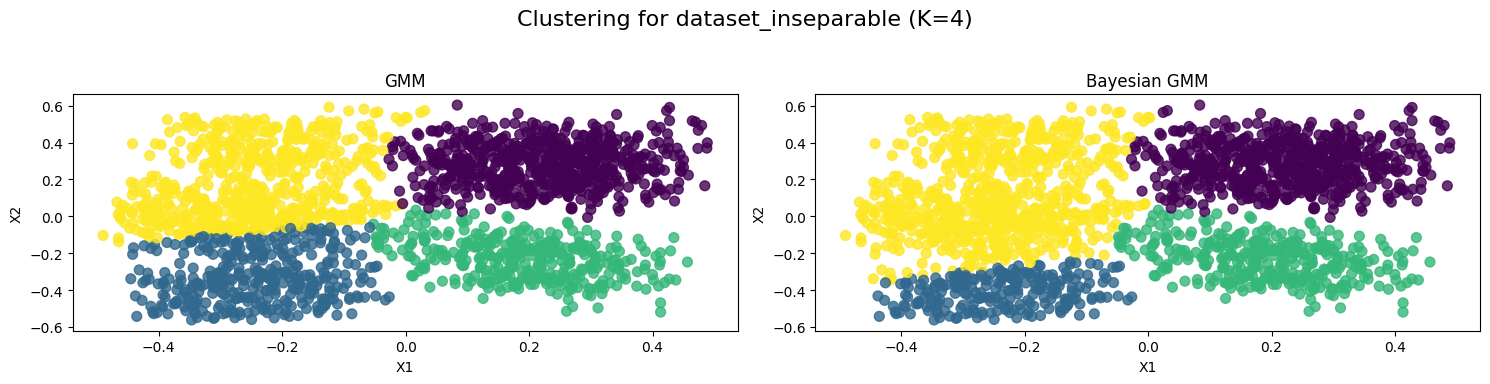

In [141]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
import matplotlib.pyplot as plt

datasets_to_test = [
    "dataset_circulos_concentricos.xlsx",
    "dataset_cuatro_diferente_densidad.xlsx",
    "dataset_cuatro_separables_peque.xlsx",
    "dataset_cuatro_diferente_medida.xlsx",
    "dataset_inseparable.xlsx"
]

for dataset_name in datasets_to_test:
    print(f"\nProcessing dataset: {dataset_name}")
    D = cargar_dataset(dataset_name)
    # Assuming the data format is consistent, taking columns 1 and 2 as features
    Dx = D[:, 1:3]

    # For this experiment, we will keep K=4 as per the previous examples,
    # but K might need adjustment for optimal results on different datasets.
    K = 4

    models = {
        "GMM": GaussianMixture(n_components=K, covariance_type='full', random_state=0),
        "Bayesian GMM": BayesianGaussianMixture(n_components=K, covariance_type='full', random_state=0)
    }

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f'Clustering for {dataset_name.replace(".xlsx", "")} (K={K})', fontsize=16)

    for (name, model), ax in zip(models.items(), axes):
        model.fit(Dx)
        labels = model.predict(Dx) # Use predict for direct labels
        ax.scatter(Dx[:, 0], Dx[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
        ax.set_title(name)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

# 🚀 ¡TALLER FINALIZADO!"